In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gradio as gr

import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D


In [2]:
# Install KaggleHub
!pip install kagglehub --quiet

import kagglehub

# Download dataset
path = kagglehub.dataset_download("adityasinghsengar122/analytica-main-problem")
print("✅ Local cached dataset path:", path)


Using Colab cache for faster access to the 'analytica-main-problem' dataset.
✅ Local cached dataset path: /kaggle/input/analytica-main-problem


In [5]:
folder_path = "/kaggle/input/analytica-main-problem/train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)

    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,tumors/tumors_2175.jpg,tumors
1,tumors/tumors_1445.jpg,tumors
2,tumors/tumors_679.jpg,tumors
3,tumors/tumors_126.jpg,tumors
4,tumors/tumors_594.jpg,tumors


In [7]:
df.tail()

,filename,category
13083,stones/stones_186.jpg,stones
13084,stones/stones_342.jpg,stones
13085,stones/stones_2565.jpg,stones
13086,stones/stones_1153.jpg,stones
13087,stones/stones_3185.jpg,stones


<Axes: xlabel='category'>

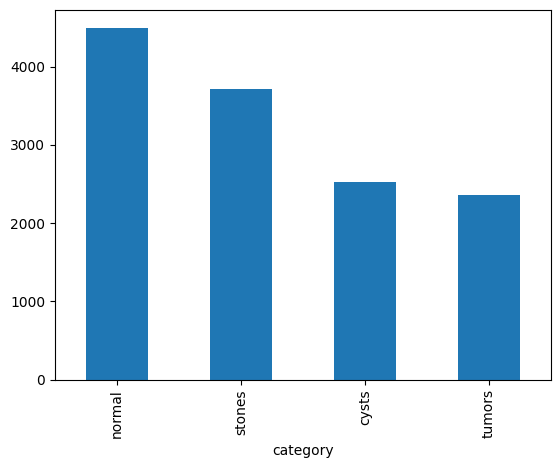

In [8]:
df['category'].value_counts().plot.bar()

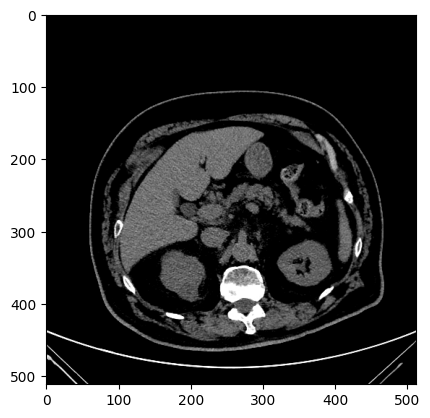

In [10]:
sample = random.choice(filenames)
image = load_img("/kaggle/input/analytica-main-problem/train/"+sample)
plt.imshow(image)

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['category'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['category'])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"\nTrain size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 9161, Val size: 1963, Test size: 1964


In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['category']),
    y=train_df['category']
)

class_weight_dict = dict(zip(np.unique(train_df['category']), class_weights))
print(f"\nClass weights: {class_weight_dict}")


Class weights: {'cysts': np.float64(1.2939265536723163), 'normal': np.float64(0.7272943791679899), 'stones': np.float64(0.8825626204238921), 'tumors': np.float64(1.3905585913782634)}


In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
IMG_SIZE = 128  # Increased from 64 to capture more detail
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    f"{path}/train",
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    # Ensure output types are correctly inferred or specified
    # Add explicit output_types if needed based on further debugging
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    f"{path}/train",
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
     # Ensure output types are correctly inferred or specified
    # Add explicit output_types if needed based on further debugging
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    f"{path}/train",
    x_col='filename',
    y_col='category',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    # Ensure output types are correctly inferred or specified
    # Add explicit output_types if needed based on further debugging
)

num_classes = len(train_generator.class_indices)
print(f"\nNumber of classes: {num_classes}")

Found 9161 validated image filenames belonging to 4 classes.
Found 1963 validated image filenames belonging to 4 classes.
Found 1964 validated image filenames belonging to 4 classes.

Number of classes: 4


In [16]:
def build_deep_cnn(input_shape=(128, 128, 3), num_classes=4):
    """
    Deep CNN with 5 convolutional blocks
    Using BatchNormalization, Dropout, and proper architecture
    """
    model = Sequential(name='Deep_CNN_Kidney_Classifier')

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, name='conv1_1'))
    model.add(BatchNormalization(name='bn1_1'))
    model.add(Activation('relu', name='relu1_1'))
    model.add(Conv2D(32, (3, 3), padding='same', name='conv1_2'))
    model.add(BatchNormalization(name='bn1_2'))
    model.add(Activation('relu', name='relu1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(Dropout(0.25, name='dropout1'))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', name='conv2_1'))
    model.add(BatchNormalization(name='bn2_1'))
    model.add(Activation('relu', name='relu2_1'))
    model.add(Conv2D(64, (3, 3), padding='same', name='conv2_2'))
    model.add(BatchNormalization(name='bn2_2'))
    model.add(Activation('relu', name='relu2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', name='conv3_1'))
    model.add(BatchNormalization(name='bn3_1'))
    model.add(Activation('relu', name='relu3_1'))
    model.add(Conv2D(128, (3, 3), padding='same', name='conv3_2'))
    model.add(BatchNormalization(name='bn3_2'))
    model.add(Activation('relu', name='relu3_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(Dropout(0.3, name='dropout3'))

    # Block 4
    model.add(Conv2D(256, (3, 3), padding='same', name='conv4_1'))
    model.add(BatchNormalization(name='bn4_1'))
    model.add(Activation('relu', name='relu4_1'))
    model.add(Conv2D(256, (3, 3), padding='same', name='conv4_2'))
    model.add(BatchNormalization(name='bn4_2'))
    model.add(Activation('relu', name='relu4_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool4'))
    model.add(Dropout(0.3, name='dropout4'))

    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same', name='conv5_1'))
    model.add(BatchNormalization(name='bn5_1'))
    model.add(Activation('relu', name='relu5_1'))
    model.add(Conv2D(512, (3, 3), padding='same', name='conv5_2'))
    model.add(BatchNormalization(name='bn5_2'))
    model.add(Activation('relu', name='relu5_2'))
    model.add(GlobalAveragePooling2D(name='gap'))
    model.add(Dropout(0.4, name='dropout5'))

    # Fully Connected Layers
    model.add(Dense(512, name='fc1'))
    model.add(BatchNormalization(name='bn_fc1'))
    model.add(Activation('relu', name='relu_fc1'))
    model.add(Dropout(0.5, name='dropout_fc1'))

    model.add(Dense(256, name='fc2'))
    model.add(BatchNormalization(name='bn_fc2'))
    model.add(Activation('relu', name='relu_fc2'))
    model.add(Dropout(0.5, name='dropout_fc2'))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

model = build_deep_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes)
print("\nModel Architecture:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Architecture:


Model: "Deep_CNN_Kidney_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 16, 16, 256)    │       295,16

 Total params: 5,118,244 (19.52 MB)

 Trainable params: 5,112,740 (19.50 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [17]:
def categorical_focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal loss for handling class imbalance
    Focuses on hard-to-classify examples
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate focal term
        weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
        focal_loss = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    return focal_loss_fixed

In [18]:
initial_lr = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss=categorical_focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')],
    run_eagerly=True # Add run_eagerly=True for better debugging
)

In [19]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
    mode='max'
)

checkpoint = ModelCheckpoint(
    'best_kidney_cnn_scratch.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [20]:
EPOCHS = 25

print("\nStarting training...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.4470 - loss: 0.2337 - precision: 0.5108 - recall: 0.2754
Epoch 1: val_accuracy improved from -inf to 0.29394, saving model to best_kidney_cnn_scratch.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 222s 734ms/step - accuracy: 0.4472 - loss: 0.2335 - precision: 0.5112 - recall: 0.2757 - val_accuracy: 0.2939 - val_loss: 1.1192 - val_precision: 0.2935 - val_recall: 0.2929 - learning_rate: 0.0010
Epoch 2/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.6276 - loss: 0.1262 - precision: 0.7672 - recall: 0.4125
Epoch 2: val_accuracy improved from 0.29394 to 0.66072, saving model to best_kidney_cnn_scratch.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 199s 691ms/step - accuracy: 0.6276 - loss: 0.1261 - precision: 0.7673 - recall: 0.4126 - val_accuracy: 0.6607 - val_loss: 0.2837 - val_precision: 0.7042 - val_recall: 0.5604 - learning_rate: 0.0010
Epoch 3/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.6738 - loss: 0.1005 - precision: 0.8246 - recall: 0.4723
Epoch 3: val_accuracy did not improve from 0.66072
287/287 ━━━━━━━━━━━━━━━━━━━━ 196s 682ms/step - accuracy: 0.6738 - loss: 0.1005 - precision: 0.8246 - recall: 0.4723 - val_accuracy: 0.5171 - val_loss: 0.1449 - val_precision: 0.6760 - val_recall: 0.4167 - learning_rate: 0.0010
Epoch 4/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6948 - loss: 0.0918 - precision: 0.8329 - recall: 0.5106
Epoch 4: val_accuracy did not improve from 0.66072
287/287 ━━━━━━━━━━━━━━━━━━━━ 197s 686ms/step - accuracy: 0.6948 - loss: 0.0918 - precision: 0.8329 - recall: 0.5106 - val_accuracy: 0.6062 - val_loss: 0.0918 - val_precision: 0.6935 - val_recall

287/287 ━━━━━━━━━━━━━━━━━━━━ 195s 679ms/step - accuracy: 0.7470 - loss: 0.0714 - precision: 0.8554 - recall: 0.5945 - val_accuracy: 0.7280 - val_loss: 0.0721 - val_precision: 0.8152 - val_recall: 0.6291 - learning_rate: 0.0010
Epoch 8/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.7380 - loss: 0.0731 - precision: 0.8318 - recall: 0.5967
Epoch 8: val_accuracy did not improve from 0.72797
287/287 ━━━━━━━━━━━━━━━━━━━━ 195s 679ms/step - accuracy: 0.7380 - loss: 0.0730 - precision: 0.8319 - recall: 0.5968 - val_accuracy: 0.4549 - val_loss: 0.1713 - val_precision: 0.5561 - val_recall: 0.3204 - learning_rate: 0.0010
Epoch 9/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7704 - loss: 0.0637 - precision: 0.8498 - recall: 0.6503
Epoch 9: val_accuracy did not improve from 0.72797
287/287 ━━━━━━━━━━━━━━━━━━━━ 195s 678ms/step - accuracy: 0.7704 - loss: 0.0636 - precision: 0.8498 - recall: 0.6503 - val_accuracy: 0.6607 - val_loss: 0.1352 - val_precision: 0.8107 - val_recall

287/287 ━━━━━━━━━━━━━━━━━━━━ 196s 682ms/step - accuracy: 0.7811 - loss: 0.0549 - precision: 0.8405 - recall: 0.6861 - val_accuracy: 0.7387 - val_loss: 0.0950 - val_precision: 0.8534 - val_recall: 0.6256 - learning_rate: 0.0010
Epoch 12/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8124 - loss: 0.0491 - precision: 0.8719 - recall: 0.7182
Epoch 12: val_accuracy did not improve from 0.73867
287/287 ━━━━━━━━━━━━━━━━━━━━ 195s 680ms/step - accuracy: 0.8124 - loss: 0.0491 - precision: 0.8718 - recall: 0.7182 - val_accuracy: 0.6729 - val_loss: 0.2348 - val_precision: 0.6826 - val_recall: 0.6388 - learning_rate: 0.0010
Epoch 13/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8163 - loss: 0.0461 - precision: 0.8509 - recall: 0.7523
Epoch 13: val_accuracy improved from 0.73867 to 0.76465, saving model to best_kidney_cnn_scratch.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 674ms/step - accuracy: 0.8163 - loss: 0.0461 - precision: 0.8509 - recall: 0.7523 - val_accuracy: 0.7646 - val_loss: 0.0528 - val_precision: 0.8024 - val_recall: 0.7056 - learning_rate: 0.0010
Epoch 14/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8185 - loss: 0.0422 - precision: 0.8605 - recall: 0.7574
Epoch 14: val_accuracy did not improve from 0.76465
287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 673ms/step - accuracy: 0.8184 - loss: 0.0422 - precision: 0.8605 - recall: 0.7574 - val_accuracy: 0.7397 - val_loss: 0.0472 - val_precision: 0.7831 - val_recall: 0.7025 - learning_rate: 0.0010
Epoch 15/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8296 - loss: 0.0416 - precision: 0.8675 - recall: 0.7700
Epoch 15: val_accuracy did not improve from 0.76465
287/287 ━━━━━━━━━━━━━━━━━━━━ 194s 676ms/step - accuracy: 0.8296 - loss: 0.0416 - precision: 0.8675 - recall: 0.7700 - val_accuracy: 0.4906 - val_loss: 0.1752 - val_precision: 0.5048 - val_re

287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 668ms/step - accuracy: 0.8290 - loss: 0.0386 - precision: 0.8604 - recall: 0.7741 - val_accuracy: 0.7860 - val_loss: 0.0599 - val_precision: 0.8133 - val_recall: 0.7524 - learning_rate: 0.0010
Epoch 17/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8341 - loss: 0.0402 - precision: 0.8660 - recall: 0.7804
Epoch 17: val_accuracy improved from 0.78604 to 0.84412, saving model to best_kidney_cnn_scratch.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 667ms/step - accuracy: 0.8341 - loss: 0.0402 - precision: 0.8660 - recall: 0.7804 - val_accuracy: 0.8441 - val_loss: 0.0333 - val_precision: 0.8626 - val_recall: 0.8217 - learning_rate: 0.0010
Epoch 18/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8402 - loss: 0.0379 - precision: 0.8704 - recall: 0.7960
Epoch 18: val_accuracy did not improve from 0.84412
287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 668ms/step - accuracy: 0.8402 - loss: 0.0379 - precision: 0.8705 - recall: 0.7960 - val_accuracy: 0.7168 - val_loss: 0.1116 - val_precision: 0.7337 - val_recall: 0.6893 - learning_rate: 0.0010
Epoch 19/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8403 - loss: 0.0360 - precision: 0.8705 - recall: 0.7997
Epoch 19: val_accuracy improved from 0.84412 to 0.87774, saving model to best_kidney_cnn_scratch.h5


287/287 ━━━━━━━━━━━━━━━━━━━━ 192s 667ms/step - accuracy: 0.8403 - loss: 0.0360 - precision: 0.8705 - recall: 0.7998 - val_accuracy: 0.8777 - val_loss: 0.0259 - val_precision: 0.8872 - val_recall: 0.8497 - learning_rate: 0.0010
Epoch 20/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8409 - loss: 0.0347 - precision: 0.8669 - recall: 0.8025
Epoch 20: val_accuracy did not improve from 0.87774
287/287 ━━━━━━━━━━━━━━━━━━━━ 190s 661ms/step - accuracy: 0.8409 - loss: 0.0347 - precision: 0.8669 - recall: 0.8025 - val_accuracy: 0.6628 - val_loss: 0.1456 - val_precision: 0.6751 - val_recall: 0.6403 - learning_rate: 0.0010
Epoch 21/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8572 - loss: 0.0316 - precision: 0.8804 - recall: 0.8199
Epoch 21: val_accuracy did not improve from 0.87774
287/287 ━━━━━━━━━━━━━━━━━━━━ 191s 665ms/step - accuracy: 0.8572 - loss: 0.0316 - precision: 0.8804 - recall: 0.8199 - val_accuracy: 0.8497 - val_loss: 0.0375 - val_precision: 0.8588 - val_re

287/287 ━━━━━━━━━━━━━━━━━━━━ 190s 662ms/step - accuracy: 0.8667 - loss: 0.0296 - precision: 0.8912 - recall: 0.8401 - val_accuracy: 0.8874 - val_loss: 0.0244 - val_precision: 0.8958 - val_recall: 0.8803 - learning_rate: 0.0010
Epoch 25/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8741 - loss: 0.0268 - precision: 0.8901 - recall: 0.8507
Epoch 25: val_accuracy did not improve from 0.88742
287/287 ━━━━━━━━━━━━━━━━━━━━ 188s 656ms/step - accuracy: 0.8741 - loss: 0.0268 - precision: 0.8901 - recall: 0.8507 - val_accuracy: 0.6551 - val_loss: 0.0885 - val_precision: 0.6829 - val_recall: 0.6286 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 24.


In [21]:
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

test_results = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_results[2]*100:.2f}%")
print(f"Test Recall: {test_results[3]*100:.2f}%")


EVALUATING ON TEST SET
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8866 - loss: 0.0225 - precision: 0.9056 - recall: 0.8782

Test Loss: 0.0220
Test Accuracy: 89.36%
Test Precision: 90.83%
Test Recall: 88.80%


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       cysts       0.88      0.97      0.92       379
      normal       0.91      0.97      0.94       675
      stones       1.00      0.78      0.87       557
      tumors       0.77      0.84      0.81       353

    accuracy                           0.89      1964
   macro avg       0.89      0.89      0.89      1964
weighted avg       0.90      0.89      0.89      1964



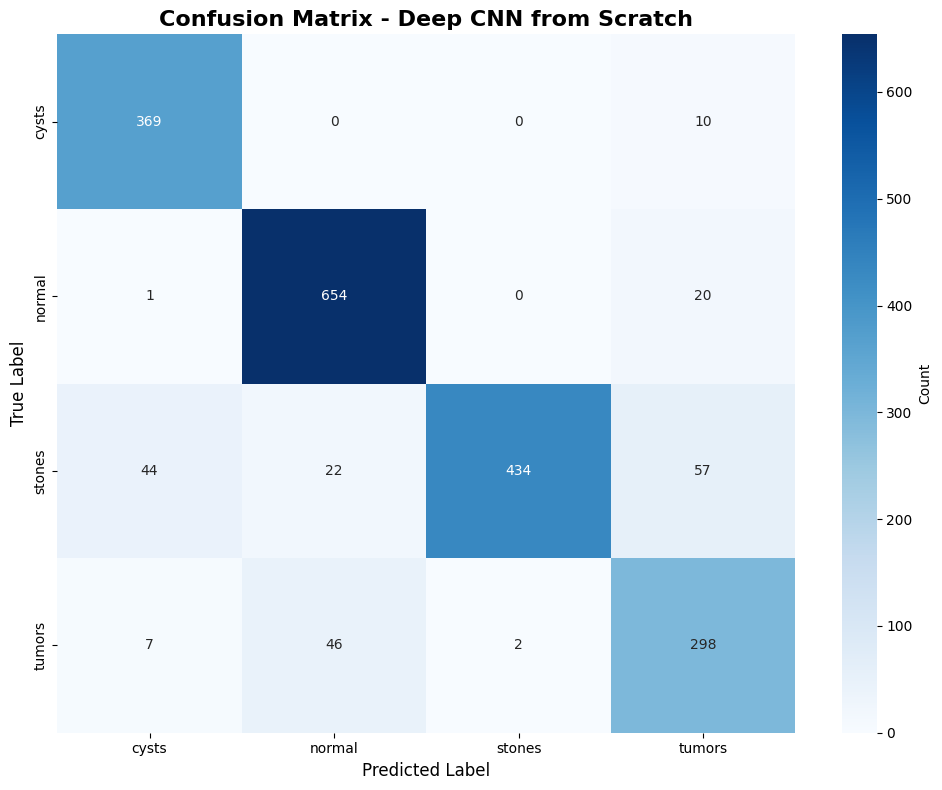

In [22]:
test_generator.reset()
predictions = model.predict(test_generator, steps=int(np.ceil(test_df.shape[0] / BATCH_SIZE)), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
from sklearn.metrics import classification_report # Import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Deep CNN from Scratch', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

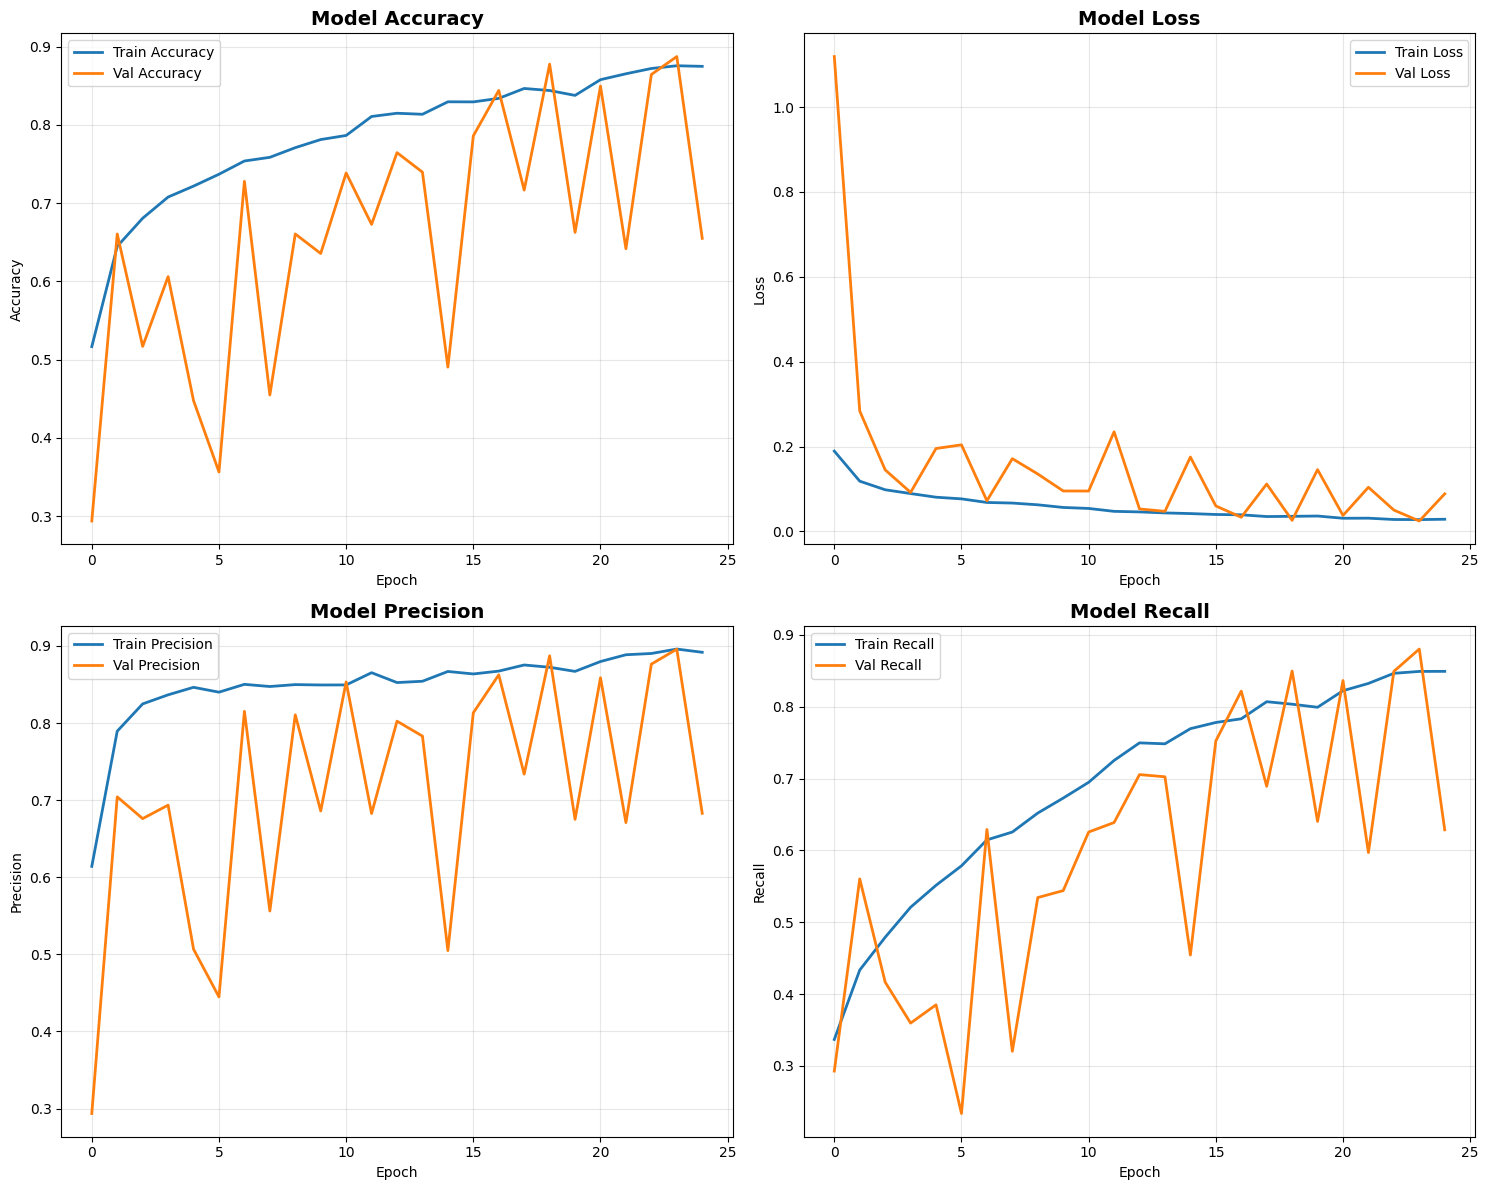

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()